In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


### 1. Load CLIP and a small PixMo-Cap subset

#### 1.1 – Load CLIP encoder

In [4]:
clip_name = "openai/clip-vit-base-patch32"
clip_proc = CLIPProcessor.from_pretrained(clip_name, use_fast=True)
clip_model = CLIPModel.from_pretrained(clip_name).eval().to(device)


In [5]:
# Inspect embedding dim D
dummy_text = ["hello world"]
with torch.no_grad():
    dummy_inputs = clip_proc(text=dummy_text, return_tensors="pt").to(device)
    dummy_text_feat = clip_model.get_text_features(**dummy_inputs)
D = dummy_text_feat.shape[-1]

print("Embedding dim D:", D)  # typically 512


Embedding dim D: 512


#### 1.2 Load PixMo-Cap and take a small slice

In [6]:
N_SAMPLES = 256  # small POC
pixmo = load_dataset("allenai/pixmo-cap", split=f"train[:{N_SAMPLES*2}]")  # grab a bit extra to survive failures
print(pixmo)


Dataset({
    features: ['image_url', 'caption', 'transcripts'],
    num_rows: 512
})


#### 1.3 – Helper: fetch image from URL

In [7]:
def fetch_image_from_url(url: str):
    try:
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        img = Image.open(BytesIO(resp.content)).convert("RGB")
        return img
    except Exception as e:
        print(f"[WARN] Failed to fetch {url[:60]}...: {e}")
        return None


#### 1.4 – Collect a clean subset of (image, caption)

In [8]:
images = []
captions = []

for ex in pixmo:
    img = fetch_image_from_url(ex["image_url"])
    if img is None:
        continue
    images.append(img)
    captions.append(ex["caption"])
    if len(images) >= N_SAMPLES:
        break

print(f"Collected {len(images)} usable image–caption pairs.")
print("Example caption:\n", captions[0][:300], "...")


[WARN] Failed to fetch http://i.imgur.com/mckPIFW.jpg?1...: 429 Client Error: Unknown Error for url: http://i.imgur.com/mckPIFW.jpg?1
[WARN] Failed to fetch https://i.imgur.com/2g6Y6D4.jpg...: 429 Client Error: Unknown Error for url: https://i.imgur.com/2g6Y6D4.jpg
[WARN] Failed to fetch http://i.imgur.com/RXvUtIx.jpg...: 429 Client Error: Unknown Error for url: http://i.imgur.com/RXvUtIx.jpg
[WARN] Failed to fetch https://assets.uigarage.net/content/uploads/2019/02/IMG_3043...: 530 Server Error: <none> for url: https://assets.uigarage.net/content/uploads/2019/02/IMG_3043-1-576x1024.png
[WARN] Failed to fetch http://i.imgur.com/O9HrtUp.png...: 429 Client Error: Unknown Error for url: http://i.imgur.com/O9HrtUp.png
[WARN] Failed to fetch https://i.imgur.com/v8AYQR2.jpg...: 429 Client Error: Unknown Error for url: https://i.imgur.com/v8AYQR2.jpg
[WARN] Failed to fetch https://i.redd.it/e8cq098bz44d1.jpeg...: 404 Client Error: Not Found for url: https://i.redd.it/e8cq098bz44d1.jpeg
[WARN]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Collected 256 usable image–caption pairs.
Example caption:
 This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall with red stains. The bird's sleek, elongated body is adorned with iridescent feathers that shimmer with shades of blue, purple, and green, most prominently on its wings and back. Its  ...


### 2. Precompute frozen CLIP embeddings (baseline)

#### 2.1 – Encoding helpers

In [9]:
@torch.no_grad()
def encode_images_clip(pil_images, batch_size=16):
    all_feats = []
    for i in range(0, len(pil_images), batch_size):
        batch_imgs = pil_images[i : i + batch_size]
        inputs = clip_proc(images=batch_imgs, return_tensors="pt").to(device)
        feats = clip_model.get_image_features(**inputs)
        feats = F.normalize(feats, dim=-1)
        all_feats.append(feats.cpu())
    return torch.cat(all_feats, dim=0)  # (N, D)

@torch.no_grad()
def encode_texts_clip(texts, batch_size=32):
    all_feats = []
    for i in range(0, len(texts), batch_size):
        batch_txt = texts[i : i + batch_size]
        inputs = clip_proc(text=batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)
        feats = clip_model.get_text_features(**inputs)
        feats = F.normalize(feats, dim=-1)
        all_feats.append(feats.cpu())
    return torch.cat(all_feats, dim=0)  # (N, D)


#### 2.2 – Compute and store embeddings

In [10]:
img_feats = encode_images_clip(images)   # (N, D)
txt_feats = encode_texts_clip(captions)  # (N, D)

print("Image feats:", img_feats.shape)
print("Text feats:", txt_feats.shape)


Image feats: torch.Size([256, 512])
Text feats: torch.Size([256, 512])


In [11]:
img_feats = img_feats.to(device)
txt_feats = txt_feats.to(device)
N = img_feats.shape[0]
print("Final N:", N, "D:", D)


Final N: 256 D: 512


### 3. Baseline retrieval (CLIP only, no projector)

#### 3.1 – Recall@K helper

In [12]:
def compute_recall_at_k(sim_matrix, k=1):
    """
    sim_matrix: (N_images, N_texts)
    Assumes correct caption for image i is at index i.
    """
    sim_np = sim_matrix.detach().cpu().numpy()
    N_images, M = sim_np.shape
    ranks = np.argsort(-sim_np, axis=1)  # sort descending
    hits = 0
    for i in range(N_images):
        if i in ranks[i, :k]:
            hits += 1
    return hits / N_images


#### 3.2 – Baseline similarity + recall

In [13]:
with torch.no_grad():
    S_full_clip = img_feats @ txt_feats.T   # (N, N)

r1_clip = compute_recall_at_k(S_full_clip, k=1)
r5_clip = compute_recall_at_k(S_full_clip, k=5)

print(f"[CLIP baseline] Recall@1={r1_clip:.3f}, Recall@5={r5_clip:.3f}")


[CLIP baseline] Recall@1=0.918, Recall@5=0.973


### 4. Matryoshka-style projector on top of CLIP

#### 4.1 – Concept

We add small trainable projectors:

z_img = P_img(img_feats)

z_txt = P_txt(txt_feats)

Then for dims dims = [64, 128, 256, D]:

For each d:

z_img_d = norm(z_img[:, :d])

z_txt_d = norm(z_txt[:, :d])

Build CLIP-style contrastive loss at depth d

Final loss = average over depths.

#### 4.2 – Define projector module

In [14]:
class SimpleProjector(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # One linear layer; you can add nonlinearity/hidden if you like
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        # x: (B, D)
        z = self.proj(x)
        return z


In [15]:
P_img = SimpleProjector(D).to(device)
P_txt = SimpleProjector(D).to(device)

params = list(P_img.parameters()) + list(P_txt.parameters())
print("Trainable parameters:", sum(p.numel() for p in params))


Trainable parameters: 525312


#### 4.3 – Matryoshka CLIP-style loss

In [16]:
def matryoshka_clip_loss(z_img, z_txt, dims, tau=0.07):
    """
    z_img, z_txt: (B, D)
    dims: list of prefix dims, e.g. [64, 128, 256, D]
    """
    B, D = z_img.shape
    labels = torch.arange(B, device=z_img.device)

    losses = []
    for d in dims:
        zi = F.normalize(z_img[:, :d], dim=-1)
        zt = F.normalize(z_txt[:, :d], dim=-1)

        # similarities scaled by temperature tau
        logits = (zi @ zt.T) / tau   # (B, B)

        loss_i = F.cross_entropy(logits, labels)      # image → text
        loss_t = F.cross_entropy(logits.T, labels)    # text → image

        losses.append(0.5 * (loss_i + loss_t))

    return sum(losses) / len(losses)


In [17]:
candidate_dims = [64, 128, 256, D]
dims_mrl = sorted(set(d for d in candidate_dims if d <= D))
print("Matryoshka depths:", dims_mrl)

Matryoshka depths: [64, 128, 256, 512]


#### 4.4 – Training data loader in embedding space

In [18]:
from torch.utils.data import Dataset, DataLoader

class EmbeddingPairDataset(Dataset):
    def __init__(self, img_feats, txt_feats):
        assert img_feats.shape == txt_feats.shape
        self.img = img_feats
        self.txt = txt_feats

    def __len__(self):
        return self.img.shape[0]

    def __getitem__(self, idx):
        return self.img[idx], self.txt[idx]

dataset = EmbeddingPairDataset(img_feats, txt_feats)
batch_size = 64
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
len(loader)


4

#### 4.5 – Train loop

In [19]:
optimizer = torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-4)
num_epochs = 5

for epoch in range(num_epochs):
    P_img.train()
    P_txt.train()
    running_loss = 0.0
    for batch_idx, (img_b, txt_b) in enumerate(loader):
        # img_b, txt_b already on device
        z_img = P_img(img_b)
        z_txt = P_txt(txt_b)

        loss = matryoshka_clip_loss(z_img, z_txt, dims_mrl, tau=0.07)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")


Epoch 1/5 - Loss: 4.2308
Epoch 2/5 - Loss: 2.9769
Epoch 3/5 - Loss: 1.6383
Epoch 4/5 - Loss: 0.5628
Epoch 5/5 - Loss: 0.2411


### 5. Evaluate retrieval with the trained projector

In [20]:
P_img.eval()
P_txt.eval()

with torch.no_grad():
    z_img_all = P_img(img_feats)   # (N, D)
    z_txt_all = P_txt(txt_feats)   # (N, D)

print(z_img_all.shape, z_txt_all.shape)


torch.Size([256, 512]) torch.Size([256, 512])


In [21]:
def recall_vs_dims(z_img, z_txt, dims, tau=1.0):
    results = []
    for d in dims:
        zi = F.normalize(z_img[:, :d], dim=-1)
        zt = F.normalize(z_txt[:, :d], dim=-1)

        S = (zi @ zt.T) * tau  # tau here is just a scaling; optional
        r1 = compute_recall_at_k(S, k=1)
        r5 = compute_recall_at_k(S, k=5)
        results.append({"dim": d, "r1": r1, "r5": r5})
        print(f"d={d:4d} → Recall@1={r1:.3f}, Recall@5={r5:.3f}")
    return results

results_mrl = recall_vs_dims(z_img_all, z_txt_all, dims_mrl)


d=  64 → Recall@1=0.965, Recall@5=0.992
d= 128 → Recall@1=0.988, Recall@5=1.000
d= 256 → Recall@1=0.992, Recall@5=1.000
d= 512 → Recall@1=0.996, Recall@5=1.000


#### 5.3 – Recall vs dimension for raw CLIP (no projector)

In [22]:
with torch.no_grad():
    # reuse the frozen features we had
    results_clip = recall_vs_dims(img_feats, txt_feats, dims_mrl)


d=  64 → Recall@1=0.359, Recall@5=0.621
d= 128 → Recall@1=0.285, Recall@5=0.562
d= 256 → Recall@1=0.762, Recall@5=0.922
d= 512 → Recall@1=0.918, Recall@5=0.973


### 6. Plots: effect of Matryoshka projector

#### 6.1 – Plot Recall@1 curves

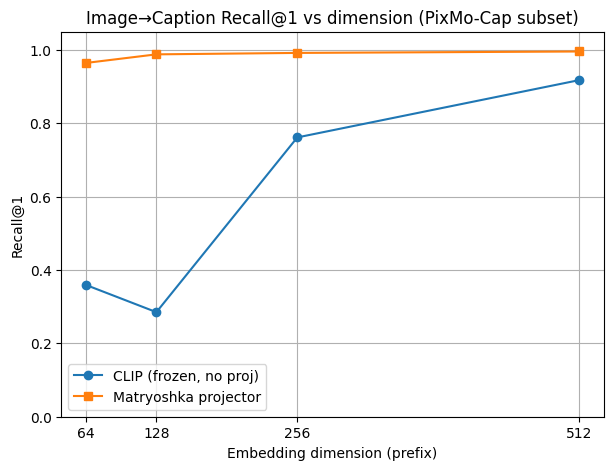

In [23]:
dims_list = [r["dim"] for r in results_mrl]

r1_mrl = [r["r1"] for r in results_mrl]
r1_clip = [r["r1"] for r in results_clip]

plt.figure(figsize=(7,5))
plt.plot(dims_list, r1_clip, marker="o", label="CLIP (frozen, no proj)")
plt.plot(dims_list, r1_mrl,  marker="s", label="Matryoshka projector")
plt.xlabel("Embedding dimension (prefix)")
plt.ylabel("Recall@1")
plt.title("Image→Caption Recall@1 vs dimension (PixMo-Cap subset)")
plt.xticks(dims_list)
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()
